# DTSA 5511: Introduction to Deep Learning
## Week 3: CNN Cancer Detection Kaggle Mini-Project

## Overview, Purpose, and Data  
### Project Challenge  
For this challenge, we are tasked with creating an algorithm using Convolutional Neural Networks to identify metastatic cancer from image samples. Techniques like this are used in medical fields today to assist doctors in appropriately interpretting images from patients.  
### Data Source
Data for this project was obtained from the [Kaggle Histopathological Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) competition.
### Data Import Tasks  
Note for this assignment, since we are looking for images, I won't directly import all of the data like we would in a csv file. Instead, I will import training labels and then we will need to loop over the images as we are training our models.

In [1]:
# Initial setup steps
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Activation, CenterCrop, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model


In [2]:
# Data import steps
training_labels = pd.read_csv('./Data/histopathologic-cancer-detection/train_labels.csv')
train_images_dir = "./Data/histopathologic-cancer-detection/train/"
test_images_dir = "./Data/histopathologic-cancer-detection/test/"

In [4]:
training_labels.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# Explore basic data information
print(f"The training data set contains {training_labels.shape[0]} images in the TIFF format.")
print(f"{len(os.listdir(test_images_dir))} test images provided.")
print(f"We are provided label data with entries: {', '.join(training_labels.columns)}.")
print("Data types are as follows:")
print(training_labels.dtypes)


The training data set contains 220025 images in the TIFF format.
57458 test images provided.
We are provided label data with entries: id, label.
Data types are as follows:
id       object
label     int64
dtype: object


## Exploratory Data Analysis

### Distribution of Classes  
We know for this data that we are looking to determine whether the image contains tumor cells or not with 0 indicating no tumor present and 1 indicating at least one cell. Our training data is distributed as follows.

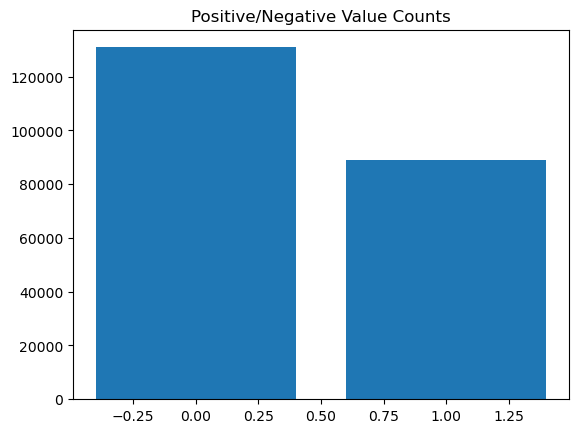

There appear to be 130908 entries with no tumors detected and 89117 with detection.


In [5]:
# Explore distribution of classes
count = training_labels['label'].value_counts()
plt.bar(count.index, count.values)
plt.title('Positive/Negative Value Counts')
plt.show()
print(f"There appear to be {count[0]} entries with no tumors detected and {count[1]} with detection.")

### Cleaning  
For this particular data set we are really only provided images. The challenge details note that duplicate images have already been removed.  

In order to use the Keras flow_from_dataframe ImageDataGenerator method, which I intend to use, I have to add the file extension to the training_labels dataframe ids. This is performed below. 

One counter note to this is that we are only supposed to look at the center 32 x 32 pixels in the images. The outer area is provided to allow for the addition of padding in the models. I will shrink down the images as we go to analyze them.

In [4]:
# Add .tif file extension to id field in the training_labels dataframe
training_labels['id'] = training_labels['id'] + '.tif'
training_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [5]:
# Convert label column to strings to be able to use in binary flow from dataframe
training_labels['label'] = training_labels['label'].astype(str)

### Visualization of Data  

Below we will take a quick look at a small sample of the data set, to get an idea of what we are working with.

In [7]:
training_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


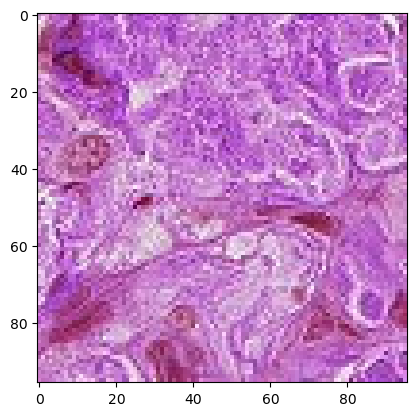

In [10]:
# Visualize sample of training data
index_sample = np.random.randint(0, 100, 9)
id_sample = [training_labels['id'][indx] for indx in index_sample]
image_sample = [cv2.imread(train_images_dir + id) for id in id_sample]
label_sample = [training_labels['label'][indx] for indx in index_sample]

# fig = plt.figure(figsize=(10, 10))
# axes = fig.subplots(nrows=3, ncols=3)
# for i in range(3):
#     for j in range(3):
#        axes[i,j].imshow(image_sample[i * 3 + j])
#         axes[i,j].set_title(bool(int(label_sample[i * 3 + j])))
#         axes[i,j].axis("off")
#plt.show()
for img in image_sample:
    plt.imshow(img)

## Model Architecture  
For this assignment, I will first start with the basic building block of a neural network focuses on image classification, the 2d Convolution Layer -> 2d Convolution Layer -> Pooling Layer -> Dense Layer -> Output Layer. I will then add in Convolution, Convolution, Pooling blocks to this model to get an idea of how adding in those blocks affect the model.  

Next I will explore some how tweaking some of the hyper parameters like learning rate and pooling method to see how the model performs.  

The models should be suitable for the task as they are aimed at as they are the fundamental building blocks used to analyze images. Our images are relatively small, looking at an area of only 32 pixels by 32 pixels, so the stride itself should also be set small to only 1 or 2 as it may miss important information otherwise. Similarly, we would not want overly large filters, so we will limit to 3x3 filters.

### Create Data Generator  

Next I will create a data generator which will read in the image files from the directory in batches.

In [6]:
# Data generator from cleaned dataframe
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=.20
)

generator_args = dict(dataframe=training_labels,
    directory=train_images_dir,
    x_col='id',
    y_col='label',
    class_mode='binary',
    batch_size=32,
    seed=1234,
    target_size=(96,96)
)

train_generator = image_generator.flow_from_dataframe(
    **generator_args,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    **generator_args,
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Model 1  
Leveraging 2D Convolution Layer -> 2D Convolution Layer -> Pooling Layer -> Denser Layer -> Output Layer

In [11]:
# First CNN Model with simple block
model1 = Sequential()

## Crop image to center 32 x 32 pixel image as specfied in task
model1.add(CenterCrop(32, 32, input_shape=(96,96,3)))

## Add convolution layer block
model1.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
model1.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
model1.add(MaxPool2D(pool_size=2))

## Add dense blocks
model1.add(Flatten())
model1.add(Dense(units=128, activation="relu"))
model1.add(Dense(units=1, activation="sigmoid"))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-30 11:22:41.192144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 11:22:41.192300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                        

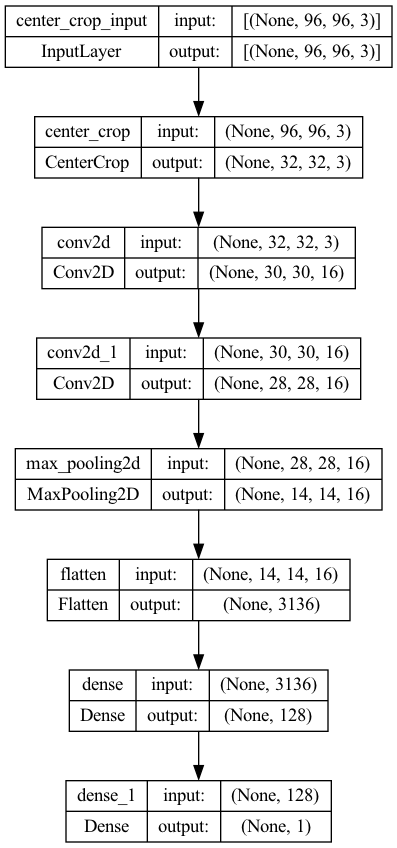

In [13]:
plot_model(model1, show_shapes=True)

In [14]:
# Train model on data
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model1_result = model1.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5


2023-03-30 11:22:59.223313: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-30 11:22:59.443946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.7731

2023-03-30 11:24:17.722492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 96s 17ms/step - loss: 0.4886 - accuracy: 0.7731 - val_loss: 0.4672 - val_accuracy: 0.7881
Epoch 2/5
5501/5501 [==============================] - 93s 17ms/step - loss: 0.4471 - accuracy: 0.7989 - val_loss: 0.4487 - val_accuracy: 0.8013
Epoch 3/5
5501/5501 [==============================] - 93s 17ms/step - loss: 0.4304 - accuracy: 0.8073 - val_loss: 0.4456 - val_accuracy: 0.8000
Epoch 4/5
5501/5501 [==============================] - 93s 17ms/step - loss: 0.4168 - accuracy: 0.8143 - val_loss: 0.4323 - val_accuracy: 0.8077
Epoch 5/5
5501/5501 [==============================] - 92s 17ms/step - loss: 0.4031 - accuracy: 0.8197 - val_loss: 0.4394 - val_accuracy: 0.8061


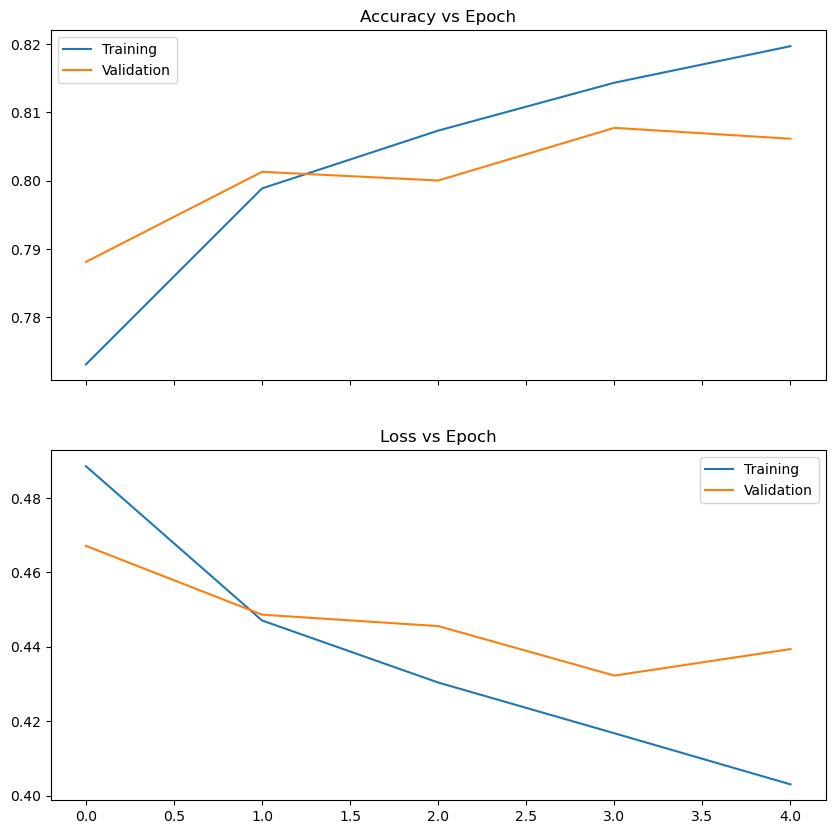

In [23]:
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(model1_result.history['accuracy'])
axes[0].plot(model1_result.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(model1_result.history['loss'])
axes[1].plot(model1_result.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Results and Analysis for Model 1  

From our graphs we can see that model 1 performed with approximately 0.81 accuracy on our training data and just over .80 on our data reserved for validation. I performed this training over only 5 epochs, however we did start to see some fall in accuracy and conversely rise in the values of our loss function which could indicate we had already found the best weights and biases for our model, or it could have just been a minor plateau.  

In model 2 we will build a more robust model and experiment with tuning the epoch and learning rate hyperparameters.

### Model 2  

For model 2, I will take the approach of doubling the number of standard convolutional blocks. I will also introduce dropout layers which will help to avoid overfitting of the model.

In [7]:
# Model 2
model2 = Sequential()

## Crop image to center 32 x 32 pixel image as specfied in task
model2.add(CenterCrop(32, 32, input_shape=(96,96,3)))

## Add 1st convolution layer block
model2.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
model2.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
model2.add(MaxPool2D(pool_size=2))

## Add 2nd convolution layer block
model2.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
model2.add(Conv2D(filters=16, kernel_size=3, activation="relu"))
model2.add(MaxPool2D(pool_size=2))

## Add dense blocks
model2.add(Flatten())
model2.add(Dense(units=128, activation="relu"))
model2.add(Dropout(.2))
model2.add(Dense(units=1, activation="sigmoid"))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-01 09:30:57.300350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-01 09:30:57.300484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


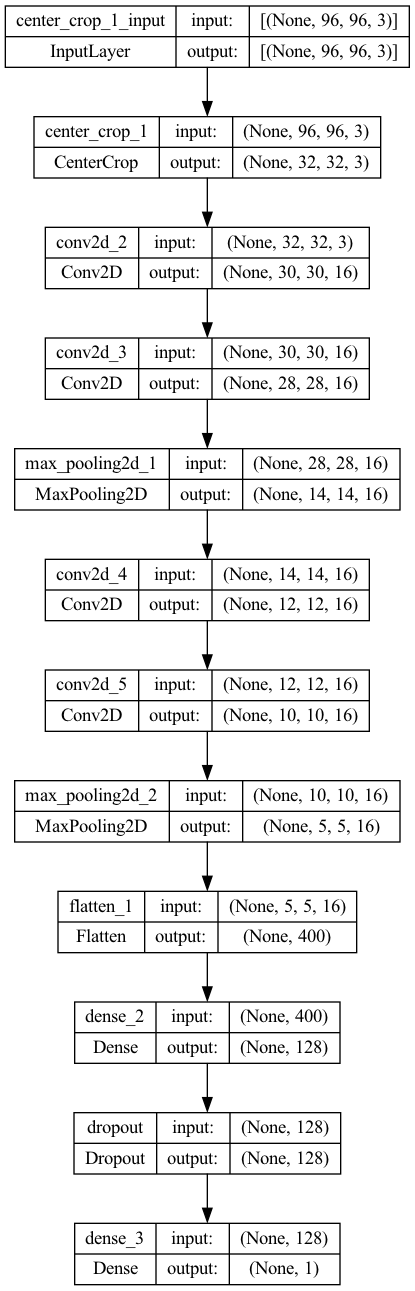

In [25]:
plot_model(model2, show_shapes=True)

In [27]:
# Train model on data
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model2_result = model2.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5


2023-03-31 11:50:33.093290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5500/5501 [============================>.] - ETA: 0s - loss: 0.4946 - accuracy: 0.7682

2023-03-31 11:51:51.078115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 97s 18ms/step - loss: 0.4946 - accuracy: 0.7682 - val_loss: 0.4690 - val_accuracy: 0.7911
Epoch 2/5
5501/5501 [==============================] - 93s 17ms/step - loss: 0.4497 - accuracy: 0.7967 - val_loss: 0.4435 - val_accuracy: 0.8031
Epoch 3/5
5501/5501 [==============================] - 93s 17ms/step - loss: 0.4325 - accuracy: 0.8072 - val_loss: 0.4309 - val_accuracy: 0.8084
Epoch 4/5
5501/5501 [==============================] - 92s 17ms/step - loss: 0.4219 - accuracy: 0.8127 - val_loss: 0.4111 - val_accuracy: 0.8195
Epoch 5/5
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4103 - accuracy: 0.8174 - val_loss: 0.4131 - val_accuracy: 0.8133


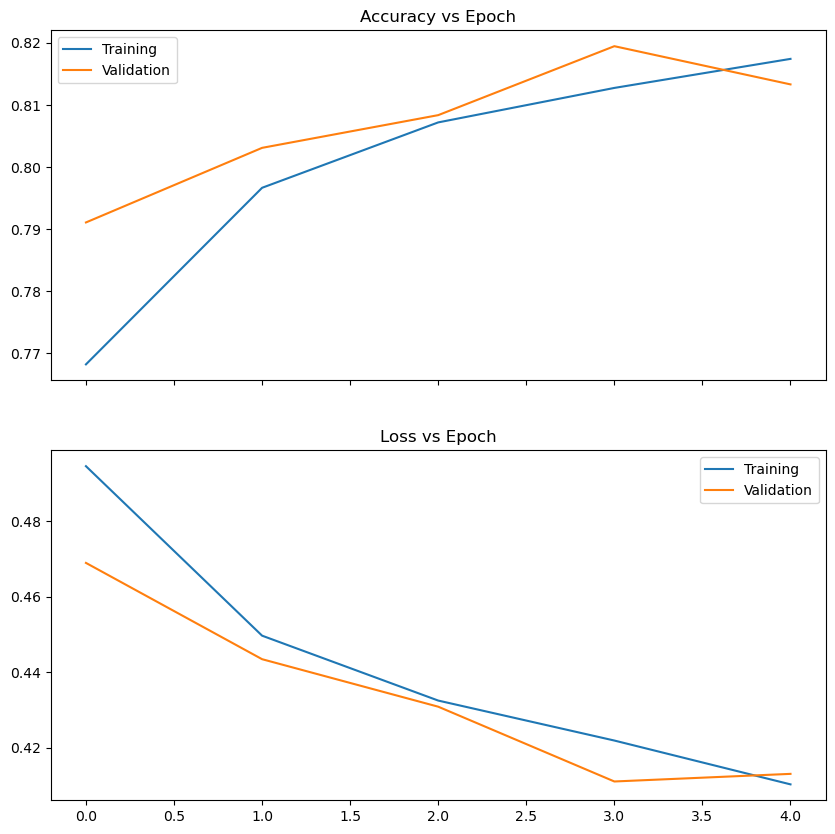

In [28]:
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(model2_result.history['accuracy'])
axes[0].plot(model2_result.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(model2_result.history['loss'])
axes[1].plot(model2_result.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Results and Analysis for Model 2  

From this, we can see that there is a slight improvement in the accuracy by introducing these changes. The accuracy on our training data remains about the same, but the accuracy of our validation data goes from 0.80 to somewhere between 0.81 and 0.82.  

It does look like we may already be finding a best epoch at around 4 iterations, but we will test this in the next section to determine whether that is correct.

### Hyperparameter Tuning: Learning Rate and Epochs  

In this section we will work on determining which values of learning rate and epoch perform best. Model 2 will be used for this comparison as it had the better accurary with similar run time.  

Note that because of the time it takes to run, I will only perform a few test learning rates and epochs only out to approximately 15. In a real world use case, a wider range of values would probably be used.

In [10]:
# Model 2 learning rate evaluation
# Note, because of the time constraints I am running each of these separately instead of in a loop
learning_rates = [0.001, 0.005, 0.01]
model_results = []

model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rates[0]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_results.append(model2.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=15
))

Epoch 1/15


2023-03-31 14:17:31.893733: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-31 14:17:32.131234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5499/5501 [============================>.] - ETA: 0s - loss: 0.4930 - accuracy: 0.7698

2023-03-31 14:18:51.402700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 97s 18ms/step - loss: 0.4930 - accuracy: 0.7699 - val_loss: 0.4509 - val_accuracy: 0.7962
Epoch 2/15
5501/5501 [==============================] - 96s 17ms/step - loss: 0.4505 - accuracy: 0.7954 - val_loss: 0.4286 - val_accuracy: 0.8103
Epoch 3/15
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4338 - accuracy: 0.8055 - val_loss: 0.4359 - val_accuracy: 0.8029
Epoch 4/15
5501/5501 [==============================] - 93s 17ms/step - loss: 0.4242 - accuracy: 0.8109 - val_loss: 0.4251 - val_accuracy: 0.8180
Epoch 5/15
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4161 - accuracy: 0.8152 - val_loss: 0.4230 - val_accuracy: 0.8111
Epoch 6/15
5501/5501 [==============================] - 95s 17ms/step - loss: 0.4082 - accuracy: 0.8195 - val_loss: 0.4160 - val_accuracy: 0.8161
Epoch 7/15
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4048 - accuracy: 0.8213 - val_loss: 0.4041 - val_accura

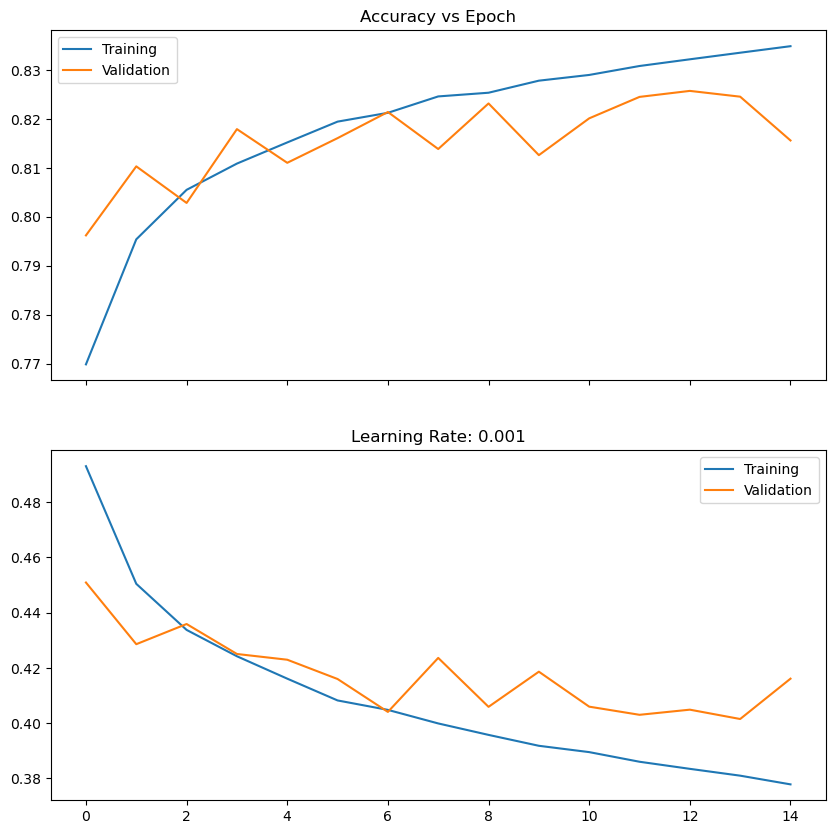

In [14]:
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(model_results[0].history['accuracy'])
axes[0].plot(model_results[0].history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(model_results[0].history['loss'])
axes[1].plot(model_results[0].history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

Judging from this, we can see that the accuracy/loss stablize somewhere around the 5 to 6 epoch range. In theory, as we increase the learning rate, the number of epochs should decrease as well. As such we will use 6 epochs for the rest as I am having processing problems going beyond that.

In [9]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_lr_005 = model2.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=6
)

Epoch 1/6


2023-04-01 09:01:31.658279: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-01 09:01:31.911287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5498/5501 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.5946

2023-04-01 09:02:52.476247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 100s 18ms/step - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6750 - val_accuracy: 0.5961
Epoch 2/6
5501/5501 [==============================] - 94s 17ms/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6746 - val_accuracy: 0.5961
Epoch 3/6
5501/5501 [==============================] - 93s 17ms/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6747 - val_accuracy: 0.5961
Epoch 4/6
5501/5501 [==============================] - 93s 17ms/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6746 - val_accuracy: 0.5961
Epoch 5/6
5501/5501 [==============================] - 92s 17ms/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6745 - val_accuracy: 0.5961
Epoch 6/6
5501/5501 [==============================] - 94s 17ms/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6747 - val_accuracy: 0.5961


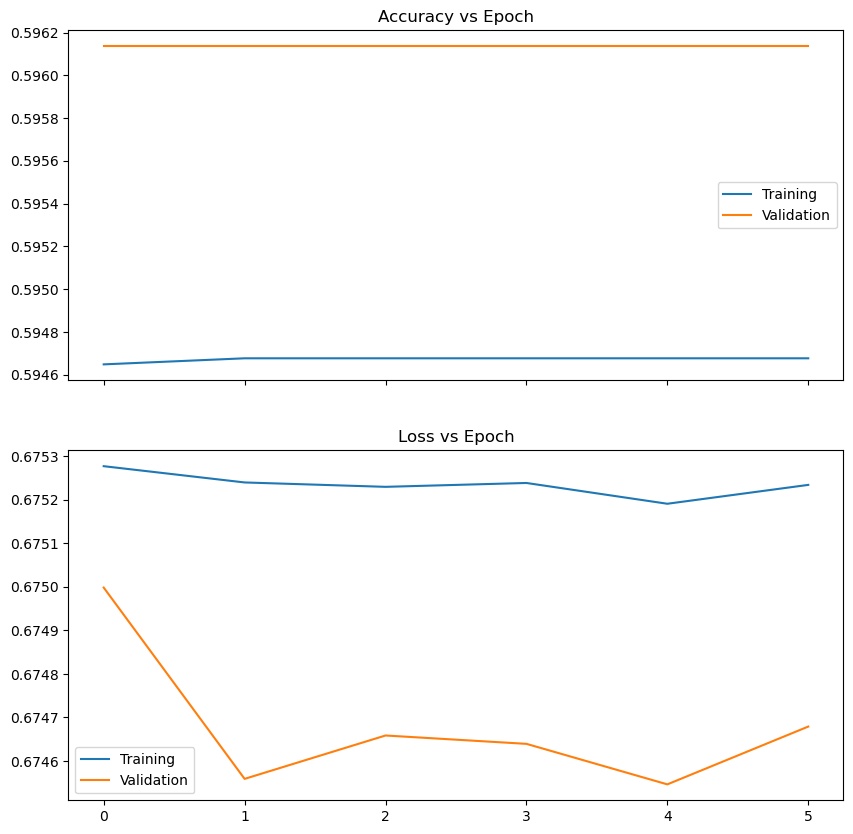

In [10]:
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(model_lr_005.history['accuracy'])
axes[0].plot(model_lr_005.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(model_lr_005.history['loss'])
axes[1].plot(model_lr_005.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

In [8]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_lr_01 = model2.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=6
)

Epoch 1/6


2023-04-01 09:14:36.332818: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-01 09:14:36.568482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5500/5501 [============================>.] - ETA: 0s - loss: 0.6754 - accuracy: 0.5943

2023-04-01 09:15:55.108706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 98s 18ms/step - loss: 0.6754 - accuracy: 0.5943 - val_loss: 0.6747 - val_accuracy: 0.5961
Epoch 2/6
5501/5501 [==============================] - 95s 17ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6751 - val_accuracy: 0.5961
Epoch 3/6
5501/5501 [==============================] - 92s 17ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6745 - val_accuracy: 0.5961
Epoch 4/6
5501/5501 [==============================] - 94s 17ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6747 - val_accuracy: 0.5961
Epoch 5/6
5501/5501 [==============================] - 94s 17ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6746 - val_accuracy: 0.5961
Epoch 6/6
5501/5501 [==============================] - 93s 17ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6746 - val_accuracy: 0.5961


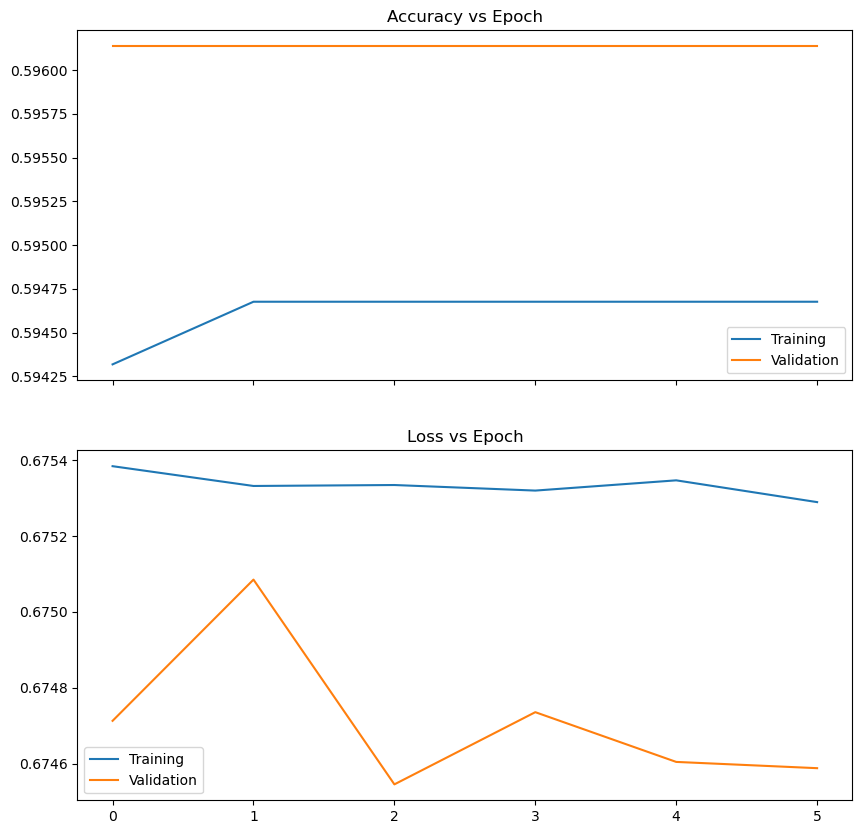

In [9]:
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(model_lr_01.history['accuracy'])
axes[0].plot(model_lr_01.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(model_lr_01.history['loss'])
axes[1].plot(model_lr_01.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Hyperparameter Tuning Analysis  

After performing this analysis, it appears that the sweet spot for epoch valuation at least for our learning rate samples is around 6. We also found that our initial learning rate of 0.001 had much better results than models with higher larger learning rates, in the 0.8 range compared to 0.6.  

As such, we will train one final model and make the predicitions required to submit a response.

## Predicitions and Submission  

In this section we will train a model with the results from our hyperparameter tuning and generate a result set which we will submit to the Kaggle competition.

In [8]:
# Final model
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_results_final = model2.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=6
)

Epoch 1/6


2023-04-01 09:31:23.271294: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-01 09:31:23.521091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.7715

2023-04-01 09:32:43.343497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 98s 18ms/step - loss: 0.4896 - accuracy: 0.7715 - val_loss: 0.4588 - val_accuracy: 0.7992
Epoch 2/6
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4475 - accuracy: 0.7987 - val_loss: 0.4290 - val_accuracy: 0.8084
Epoch 3/6
5501/5501 [==============================] - 99s 18ms/step - loss: 0.4323 - accuracy: 0.8064 - val_loss: 0.4427 - val_accuracy: 0.7961
Epoch 4/6
5501/5501 [==============================] - 100s 18ms/step - loss: 0.4205 - accuracy: 0.8133 - val_loss: 0.4373 - val_accuracy: 0.8052
Epoch 5/6
5501/5501 [==============================] - 96s 17ms/step - loss: 0.4124 - accuracy: 0.8159 - val_loss: 0.4303 - val_accuracy: 0.8114
Epoch 6/6
5501/5501 [==============================] - 92s 17ms/step - loss: 0.4065 - accuracy: 0.8198 - val_loss: 0.4087 - val_accuracy: 0.8179


In [13]:
# Data generator from cleaned dataframe
prediction_results = pd.DataFrame({"id": os.listdir(test_images_dir)})

test_image_generator = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=prediction_results,
    directory=test_images_dir,
    x_col="id",
    class_mode=None,
    batch_size=32,
    seed=123,
    target_size=(96,96)
)

Found 57458 validated image filenames.


In [14]:
# Prediction results
val_results = model2.predict(test_generator)

1796/1796 [==============================] - 23s 13ms/step


In [21]:
prediction_results['label'] = val_results.flatten()

In [26]:
prediction_results['label'] = (prediction_results['label'] >= 0.5).astype('int')

In [36]:
prediction_results['id'] = prediction_results['id'].str.replace('.tif', '')

/var/folders/pb/c_9v96_56rv7drzl9wc736cm0000gn/T/ipykernel_5099/675124003.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  prediction_results['id'] = prediction_results['id'].str.replace('.tif', '')


In [39]:
prediction_results.to_csv('CNN_Prediction_Results.csv', index=False)

## Sources

* [Tutorial on Keras ImageDataGenerator with flow_from_dataframe](https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1)
* [Keras Image Classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)